<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Análise-Exploratória-de-Dados" data-toc-modified-id="Análise-Exploratória-de-Dados-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Análise Exploratória de Dados</a></span><ul class="toc-item"><li><span><a href="#Séries-temporais" data-toc-modified-id="Séries-temporais-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Séries temporais</a></span></li><li><span><a href="#Relação-entre-duas-variáveis-continuas" data-toc-modified-id="Relação-entre-duas-variáveis-continuas-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Relação entre duas variáveis continuas</a></span></li><li><span><a href="#Relação-entre-uma-variável-continua-e-uma-categórica" data-toc-modified-id="Relação-entre-uma-variável-continua-e-uma-categórica-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Relação entre uma variável continua e uma categórica</a></span></li><li><span><a href="#Relação-entre-múltiplas-variáveis-continuas" data-toc-modified-id="Relação-entre-múltiplas-variáveis-continuas-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Relação entre múltiplas variáveis continuas</a></span></li></ul></li></ul></div>

In [2]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv("credentials/mysql.env")
url_banco = "localhost"
nome_db = "olist"
conn_str = f"mysql+pymysql://{os.getenv('MYSQL_USER')}:{os.getenv('MYSQL_PASS')}@{url_banco}/{nome_db}"
engine = create_engine(conn_str)


In [230]:
sns.set_theme(context="notebook", style="darkgrid")


Para facilitar nosso trabalho na aula de hoje, vamos criar um View com os dados que utilizaremos ao longo da aula.

# Análise Exploratória de Dados (EDA)

O processo de construção de modelos pode ser dividido em quatro etapas:

1. **Definição do Problema e Coleta de Dados**;
    * Todo modelo deve ter um **objetivo bem definido**.
    * O **tempo disponível** para construção é **parte da definição do problema**!
    * A partir desta definição podemos definir *quais dados serão necessários* para **iniciarmos nossa análise**.
1. **Análises Exploratórias**;
    * O objetivo da análise exploratória é *maximizar o nosso conhecimento* sobre a **estrutura dos dados** disponíveis, mapear as relações entre diferentes variáveis e o objetivo do nosso problema e **avaliar a qualidade dos dados**, eventualmente propondo tratativas para sanar problemas.
1. **Definição e construção do modelo**;
    * A partir do conhecimento adquirido durante a análise exploratória vamos determinar quais **técnicas são mais apropriadas** para a resolução do nosso problema.
    * Para escolher entre diferentes técnicas devemos **implantar uma infra-estrutura rudimentar de testes**, que nos permita *testar diferentes modelos de forma rápida e simples*.
1. **Validação e definição de próximos passos**.
    * Com a construção do modelo finalizada, conduziremos a validação final do modelo, apresentando os conceitos por trás deste para os diferentes stakeholders do projeto. Além disso conduziremos testes utilizando a infra-estrutura operacional do modelo, garantindo que não houve perda de performance nas condições operacionais.

Este processo **não é necessariamente linear**: podemos descobrir na etapa de análises exploratórias que não temos todas as informações necessárias para construir um modelo, ou então que as informações estão comprometidas a ponto de inviabilizar qualquer análise.

Hoje nos aprofundaremos na segunda etapa deste fluxo: a análise exploratória de dados!

## Definição do Problema

Para a aula de hoje utilizaremos o data set da Olist. Foi solicitado ao CoE de Dados que construa um modelo para explicar e prever variações nas avalições que clientes fizeram de nossos pedidos. O objetivo deste modelo é descobrir quais são os principais eixos que impactam estas avaliações para que possamos focar esforços na melhoria das áreas mais críticas.

Os dados utilizados serão os dados do case OLIST, disponíveis no nosso DB MySQL.

## Fonte de Dados

No caso da aula de hoje, utilizaremos o nosso DB MySQL como fonte de dados para nossa análise exploratória.

In [263]:
query = """
	SELECT
		oodc.order_id,
		ooidc.seller_id,
		ooidc.price,
		ooidc.freight_value,
		oodc.order_status,
		STR_TO_DATE(oodc.order_approved_at, '%%Y-%%m-%%d %%H:%%i:%%s') AS order_approved_at,
		STR_TO_DATE(ooidc.shipping_limit_date, '%%Y-%%m-%%d %%H:%%i:%%s') AS shipping_limit_date,
		STR_TO_DATE(oodc.order_delivered_carrier_date, '%%Y-%%m-%%d %%H:%%i:%%s') AS order_delivered_carrier_date,
		STR_TO_DATE(oodc.order_delivered_customer_date, '%%Y-%%m-%%d %%H:%%i:%%s') AS order_delivered_customer_date,
		STR_TO_DATE(oodc.order_estimated_delivery_date, '%%Y-%%m-%%d %%H:%%i:%%s') AS order_estimated_delivery_date,
		ocdc.customer_state,
		osdc.seller_state,
		opdc.product_category_name,
		opdc.product_weight_g,
		oordc.review_score 
	FROM 
		olist_order_items_dataset_csv ooidc JOIN
		olist_orders_dataset_csv oodc ON (ooidc.order_id = oodc.order_id) JOIN 
		olist_customers_dataset_csv ocdc ON (oodc.customer_id = ocdc.customer_id) JOIN 
		olist_products_dataset_csv opdc ON (ooidc.product_id = opdc.product_id) JOIN
		olist_sellers_dataset_csv osdc ON (osdc.seller_id = ooidc.seller_id) LEFT JOIN 
		olist_order_reviews_dataset_csv oordc ON (oodc.order_id = oordc.order_id) JOIN
		(
			SELECT
				oordc.review_id,
				STR_TO_DATE(oordc.review_creation_date, '%%Y-%%m-%%d %%H:%%i:%%s') AS review_date,
				SUM(1) OVER (PARTITION BY order_id ORDER BY order_id, STR_TO_DATE(oordc.review_creation_date, '%%Y-%%m-%%d %%H:%%i:%%s') DESC) AS cum_review
			FROM 
				olist_order_reviews_dataset_csv oordc
			ORDER BY 
				oordc.order_id,
				STR_TO_DATE(oordc.review_creation_date, '%%Y-%%m-%%d %%H:%%i:%%s') DESC
		) AS lr ON (oordc.review_id = lr.review_id)
	WHERE
		lr.cum_review = 1
	HAVING
		order_approved_at >= '2017-08-01' AND
		order_approved_at < '2018-08-01'
"""
tb_pedidos = pd.read_sql(query, engine)


In [264]:
tb_pedidos.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66136 entries, 0 to 66135
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       66136 non-null  object        
 1   seller_id                      66136 non-null  object        
 2   price                          66136 non-null  float64       
 3   freight_value                  66136 non-null  float64       
 4   order_status                   66136 non-null  object        
 5   order_approved_at              66136 non-null  datetime64[ns]
 6   shipping_limit_date            66136 non-null  datetime64[ns]
 7   order_delivered_carrier_date   65536 non-null  datetime64[ns]
 8   order_delivered_customer_date  64881 non-null  datetime64[ns]
 9   order_estimated_delivery_date  66136 non-null  datetime64[ns]
 10  customer_state                 66136 non-null  object        
 11  seller_state   

In [265]:
tb_pedidos.describe()


,price,freight_value,product_weight_g,review_score
count,66136.000000,66136.000000,66134.000000,66136.000000
mean,120.431259,20.100345,2083.401110,3.996386
std,174.447365,15.793979,3703.339539,1.415262
min,0.850000,0.000000,0.000000,1.000000
25%,39.990000,13.070000,300.000000,3.000000
50%,75.900000,16.360000,668.000000,5.000000
75%,135.705000,21.300000,1800.000000,5.000000
max,4099.990000,409.680000,40425.000000,5.000000


In [266]:
tb_pedidos.select_dtypes(include=["object"]).describe()


,order_id,seller_id,order_status,customer_state,seller_state,product_category_name
count,66136,66136,66136,66136,66136,66136
unique,57274,2455,5,27,21,74
top,1b15974a0141d54e36626dca3fdc731a,1f50f920176fa81dab994f9023523100,delivered,SP,SP,cama_mesa_banho
freq,20,1365,64885,27782,47523,6577


In [267]:
tb_pedidos.select_dtypes(include=["datetime"]).describe(datetime_is_numeric=True)


,order_approved_at,shipping_limit_date,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,66136,66136,65536,64881,66136
mean,2018-02-11 11:07:16.559044864,2018-02-17 16:20:51.841478400,2018-02-14 13:42:09.620116992,2018-02-24 02:56:05.722954240,2018-03-06 22:11:45.890891264
min,2017-08-01 00:15:18,2017-08-07 00:15:18,2017-08-01 12:08:02,2017-08-02 16:13:08,2017-08-10 00:00:00
25%,2017-11-25 04:39:01.500000,2017-11-30 19:53:46,2017-11-28 22:31:52.750000128,2017-12-08 14:33:51,2017-12-18 00:00:00
50%,2018-02-16 10:10:25,2018-02-22 11:52:57,2018-02-20 19:04:19,2018-03-03 00:51:44,2018-03-13 00:00:00
75%,2018-05-04 14:53:28.500000,2018-05-10 10:30:18.500000,2018-05-07 19:09:00,2018-05-15 14:26:52,2018-05-25 00:00:00
max,2018-07-31 23:44:07,2018-08-29 12:30:12,2018-08-22 15:07:00,2018-10-17 13:22:46,2018-09-20 00:00:00


In [268]:
colunas_data = tb_pedidos.select_dtypes(include=["datetime"]).columns

for coluna in colunas_data:
    tb_pedidos[coluna] = tb_pedidos[coluna].dt.normalize()

tb_pedidos["atraso"] = (
    tb_pedidos["order_delivered_customer_date"]
    > tb_pedidos["order_estimated_delivery_date"]
)

tb_pedidos.loc[tb_pedidos["atraso"], "dias_atraso"] = (
    tb_pedidos["order_delivered_customer_date"]
    - tb_pedidos["order_estimated_delivery_date"]
) / np.timedelta64(1, "D")
tb_pedidos.loc[~tb_pedidos["atraso"], "dias_atraso"] = 0


In [269]:
tb_pedidos = tb_pedidos.dropna()
tb_pedidos.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 64878 entries, 0 to 66135
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       64878 non-null  object        
 1   seller_id                      64878 non-null  object        
 2   price                          64878 non-null  float64       
 3   freight_value                  64878 non-null  float64       
 4   order_status                   64878 non-null  object        
 5   order_approved_at              64878 non-null  datetime64[ns]
 6   shipping_limit_date            64878 non-null  datetime64[ns]
 7   order_delivered_carrier_date   64878 non-null  datetime64[ns]
 8   order_delivered_customer_date  64878 non-null  datetime64[ns]
 9   order_estimated_delivery_date  64878 non-null  datetime64[ns]
 10  customer_state                 64878 non-null  object        
 11  seller_state   

## Distribuição e Evolução de Avaliações

In [270]:
sns.color_palette("Paired")


[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [271]:
colors = sns.color_palette("Paired")


<AxesSubplot:xlabel='review_score', ylabel='Count'>

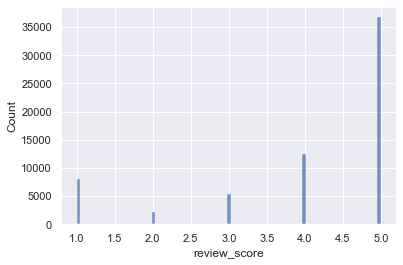

In [272]:
sns.histplot(data=tb_pedidos, x="review_score")


In [273]:
tb_pedidos["detractor"] = np.where(tb_pedidos["review_score"] <= 3, 1, 0)


In [274]:
tb_diaria = (
    tb_pedidos.groupby("order_approved_at")
    .agg(
        num_pedidos=pd.NamedAgg("order_id", "nunique"),
        avg_review=pd.NamedAgg("review_score", "mean"),
        std_review=pd.NamedAgg("review_score", "std"),
        per_detractor=pd.NamedAgg("detractor", "mean"),
        per_atraso=pd.NamedAgg("atraso", "mean"),
        avg_atraso=pd.NamedAgg("dias_atraso", "mean"),
    )
    .reset_index()
)


<AxesSubplot:xlabel='order_approved_at', ylabel='num_pedidos'>

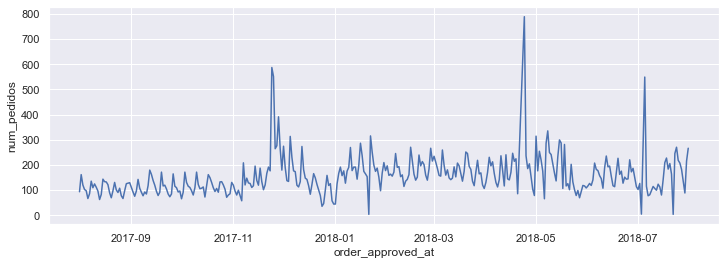

In [275]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=tb_diaria, x="order_approved_at", y="num_pedidos")


<AxesSubplot:xlabel='order_approved_at', ylabel='avg_review'>

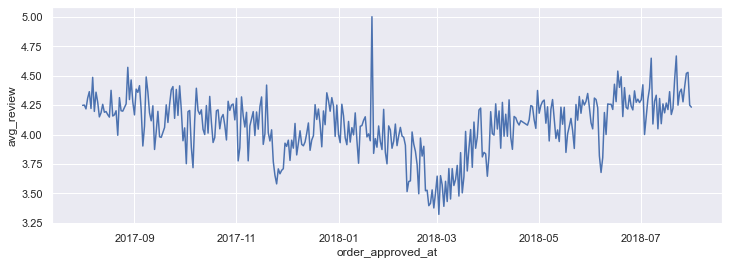

In [276]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=tb_diaria, x="order_approved_at", y="avg_review")


<AxesSubplot:xlabel='order_approved_at', ylabel='per_detractor'>

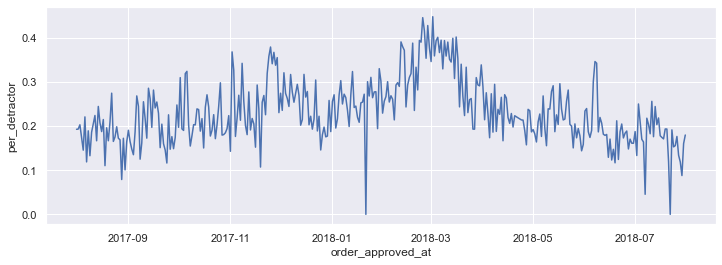

In [277]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=tb_diaria, x="order_approved_at", y="per_detractor")


<AxesSubplot:xlabel='order_approved_at', ylabel='cv_review'>

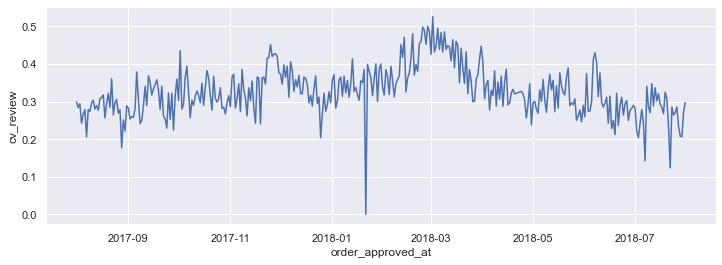

In [278]:
tb_diaria["cv_review"] = tb_diaria["std_review"] / tb_diaria["avg_review"]

plt.figure(figsize=(12, 4))
sns.lineplot(data=tb_diaria, x="order_approved_at", y="cv_review")


<AxesSubplot:xlabel='order_approved_at', ylabel='per_detractor'>

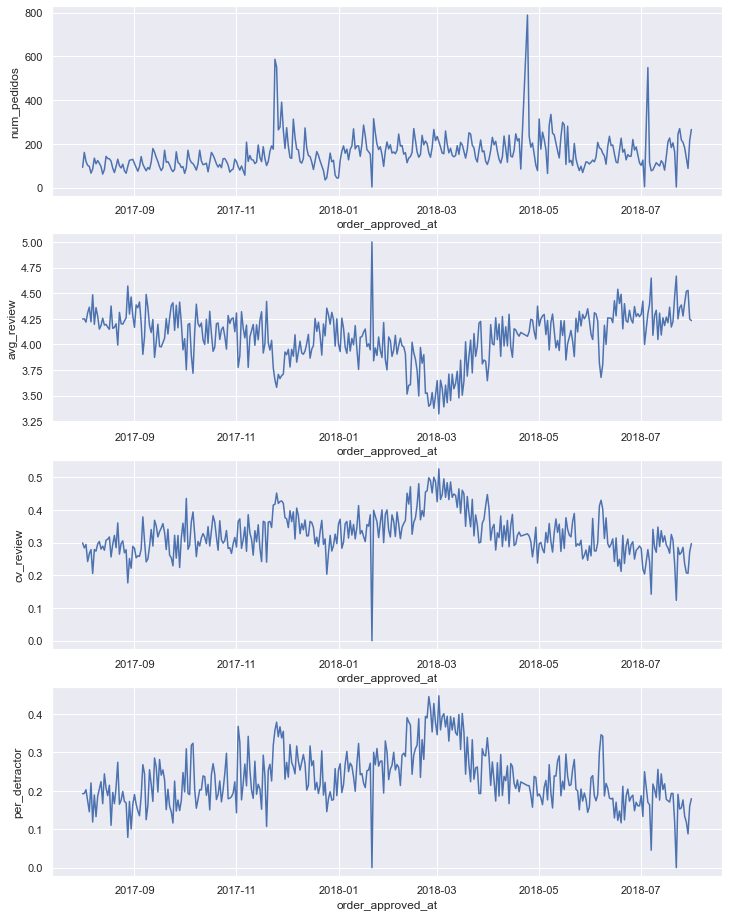

In [279]:
fig, ax = plt.subplots(4, 1, figsize=(12, 16))

sns.lineplot(data=tb_diaria, x="order_approved_at", y="num_pedidos", ax=ax[0])
sns.lineplot(data=tb_diaria, x="order_approved_at", y="avg_review", ax=ax[1])
sns.lineplot(data=tb_diaria, x="order_approved_at", y="cv_review", ax=ax[2])
sns.lineplot(data=tb_diaria, x="order_approved_at", y="per_detractor", ax=ax[3])


In [280]:
tb_diaria["mm_num_pedidos"] = tb_diaria["num_pedidos"].rolling(7).mean()
tb_diaria["mm_avg_review"] = tb_diaria["avg_review"].rolling(7).mean()
tb_diaria["mm_cv_review"] = tb_diaria["cv_review"].rolling(7).mean()
tb_diaria["mm_per_detractor"] = tb_diaria["per_detractor"].rolling(7).mean()
tb_diaria.head(10)


,order_approved_at,num_pedidos,avg_review,std_review,per_detractor,per_atraso,avg_atraso,cv_review,mm_num_pedidos,mm_avg_review,mm_cv_review,mm_per_detractor
0,2017-08-01,93,4.247706,1.270433,0.192661,0.018349,0.137615,0.299087,NaN,NaN,NaN,NaN
1,2017-08-02,161,4.250000,1.207122,0.193182,0.028409,0.380682,0.284029,NaN,NaN,NaN,NaN
2,2017-08-03,120,4.217391,1.242432,0.202899,0.021739,0.159420,0.294597,NaN,NaN,NaN,NaN
3,2017-08-04,102,4.308333,1.043554,0.175000,0.041667,0.400000,0.242218,NaN,NaN,NaN,NaN
4,2017-08-05,97,4.363636,1.163097,0.145455,0.018182,0.081818,0.266543,NaN,NaN,NaN,NaN
5,2017-08-06,66,4.220779,1.176786,0.220779,0.025974,0.272727,0.278808,NaN,NaN,NaN,NaN
6,2017-08-07,85,4.485149,0.923189,0.118812,0.019802,0.108911,0.205832,103.428571,4.298999,0.267302,0.178398
7,2017-08-08,135,4.195946,1.170259,0.189189,0.027027,0.182432,0.278902,109.428571,4.291605,0.264418,0.177902
8,2017-08-09,109,4.359375,1.195361,0.132812,0.023438,0.406250,0.274205,102.000000,4.307230,0.263015,0.169278
9,2017-08-10,124,4.275862,1.266462,0.186207,0.041379,0.324138,0.296189,102.571429,4.315583,0.263242,0.166893


<AxesSubplot:xlabel='order_approved_at', ylabel='per_detractor'>

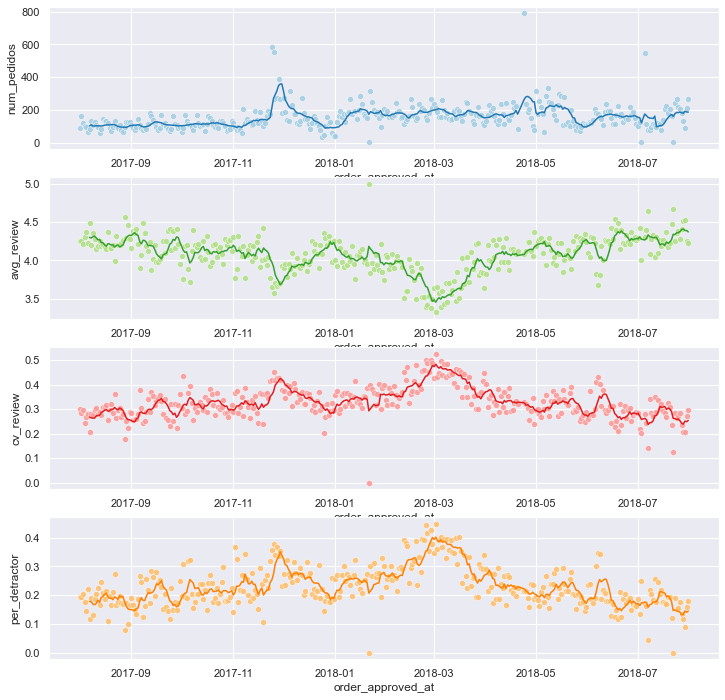

In [281]:
fig, ax = plt.subplots(4, 1, figsize=(12, 12))

sns.scatterplot(
    data=tb_diaria,
    x="order_approved_at",
    y="num_pedidos",
    color=colors[0],
    ax=ax[0],
    alpha=0.9,
)
sns.lineplot(
    data=tb_diaria, x="order_approved_at", y="mm_num_pedidos", color=colors[1], ax=ax[0]
)
sns.scatterplot(
    data=tb_diaria,
    x="order_approved_at",
    y="avg_review",
    color=colors[2],
    ax=ax[1],
    alpha=0.9,
)
sns.lineplot(
    data=tb_diaria, x="order_approved_at", y="mm_avg_review", color=colors[3], ax=ax[1]
)
sns.scatterplot(
    data=tb_diaria,
    x="order_approved_at",
    y="cv_review",
    color=colors[4],
    ax=ax[2],
    alpha=0.9,
)
sns.lineplot(
    data=tb_diaria, x="order_approved_at", y="mm_cv_review", color=colors[5], ax=ax[2]
)
sns.scatterplot(
    data=tb_diaria,
    x="order_approved_at",
    y="per_detractor",
    color=colors[6],
    ax=ax[3],
    alpha=0.9,
)
sns.lineplot(
    data=tb_diaria,
    x="order_approved_at",
    y="mm_per_detractor",
    color=colors[7],
    ax=ax[3],
)


## Relação entre duas variáveis continuas

<AxesSubplot:xlabel='num_pedidos', ylabel='avg_review'>

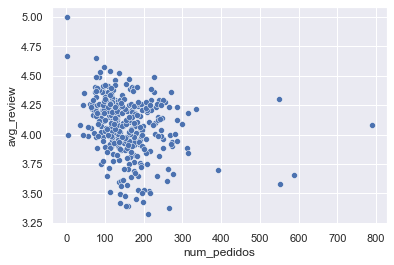

In [282]:
sns.scatterplot(data=tb_diaria, x="num_pedidos", y="avg_review")


<AxesSubplot:xlabel='mm_num_pedidos', ylabel='mm_avg_review'>

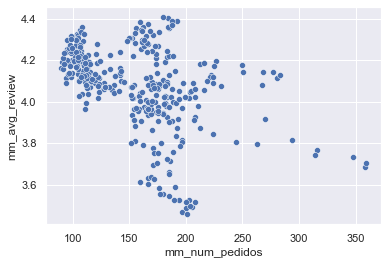

In [283]:
sns.scatterplot(data=tb_diaria, x="mm_num_pedidos", y="mm_avg_review")


<AxesSubplot:xlabel='mm_num_pedidos', ylabel='mm_avg_review'>

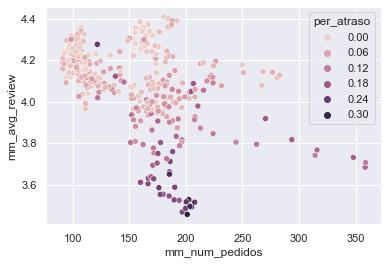

In [284]:
sns.scatterplot(data=tb_diaria, x="mm_num_pedidos", y="mm_avg_review", hue="per_atraso")


<AxesSubplot:xlabel='mm_num_pedidos', ylabel='per_atraso'>

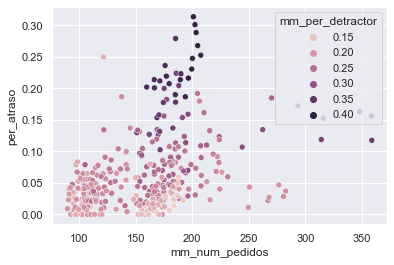

In [285]:
sns.scatterplot(
    data=tb_diaria, x="mm_num_pedidos", y="per_atraso", hue="mm_per_detractor"
)


<AxesSubplot:xlabel='per_atraso', ylabel='cv_review'>

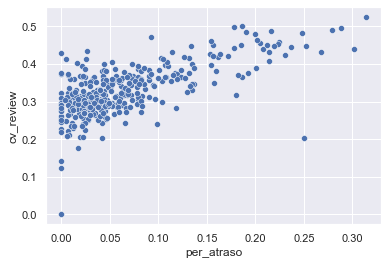

In [286]:
sns.scatterplot(data=tb_diaria, x="per_atraso", y="cv_review")


<AxesSubplot:xlabel='num_pedidos', ylabel='mm_cv_review'>

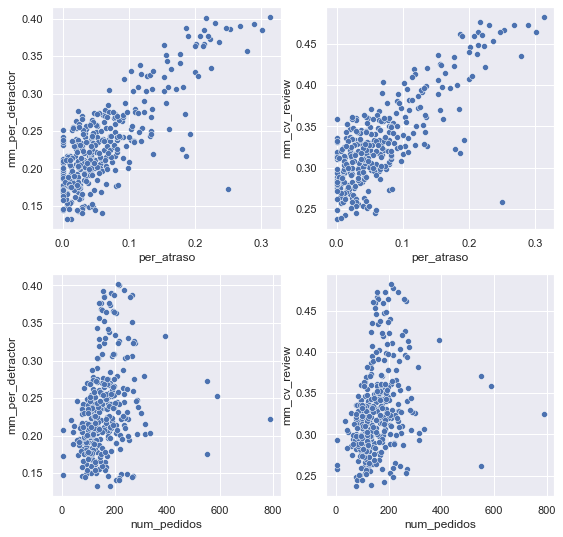

In [287]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9))
sns.scatterplot(data=tb_diaria, x="per_atraso", y="mm_per_detractor", ax=ax[0][0])
sns.scatterplot(data=tb_diaria, x="per_atraso", y="mm_cv_review", ax=ax[0][1])
sns.scatterplot(data=tb_diaria, x="num_pedidos", y="mm_per_detractor", ax=ax[1][0])
sns.scatterplot(data=tb_diaria, x="num_pedidos", y="mm_cv_review", ax=ax[1][1])


<AxesSubplot:xlabel='num_pedidos', ylabel='mm_cv_review'>

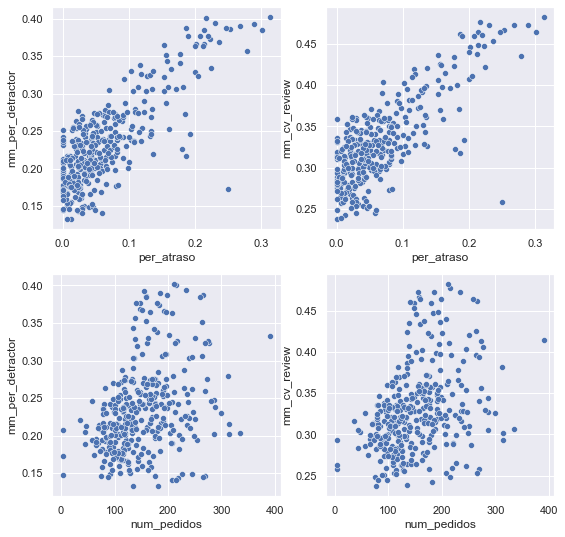

In [288]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9))
sns.scatterplot(data=tb_diaria, x="per_atraso", y="mm_per_detractor", ax=ax[0][0])
sns.scatterplot(data=tb_diaria, x="per_atraso", y="mm_cv_review", ax=ax[0][1])
sns.scatterplot(
    data=tb_diaria[tb_diaria["num_pedidos"] < 400],
    x="num_pedidos",
    y="mm_per_detractor",
    ax=ax[1][0],
)
sns.scatterplot(
    data=tb_diaria[tb_diaria["num_pedidos"] < 400],
    x="num_pedidos",
    y="mm_cv_review",
    ax=ax[1][1],
)


<AxesSubplot:xlabel='num_pedidos', ylabel='mm_cv_review'>

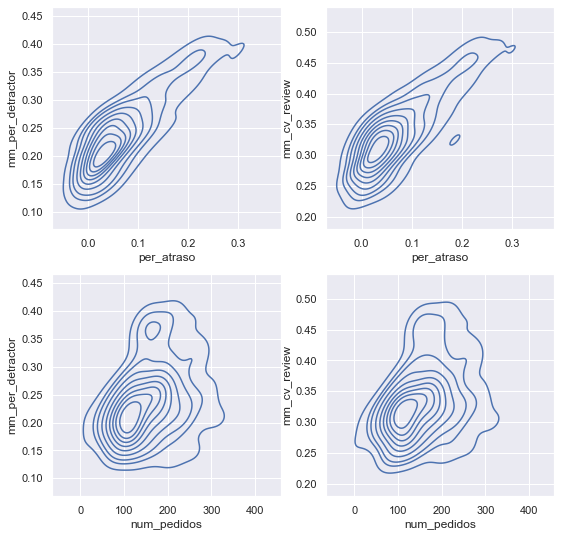

In [289]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9))
sns.kdeplot(data=tb_diaria, x="per_atraso", y="mm_per_detractor", ax=ax[0][0])
sns.kdeplot(data=tb_diaria, x="per_atraso", y="mm_cv_review", ax=ax[0][1])
sns.kdeplot(
    data=tb_diaria[tb_diaria["num_pedidos"] < 400],
    x="num_pedidos",
    y="mm_per_detractor",
    ax=ax[1][0],
)
sns.kdeplot(
    data=tb_diaria[tb_diaria["num_pedidos"] < 400],
    x="num_pedidos",
    y="mm_cv_review",
    ax=ax[1][1],
)


## Relação entre uma variável continua e uma categórica

In [290]:
tb_pedidos = tb_pedidos.merge(
    tb_diaria[["order_approved_at", "num_pedidos"]], on="order_approved_at"
)


<AxesSubplot:xlabel='detractor', ylabel='product_weight_g'>

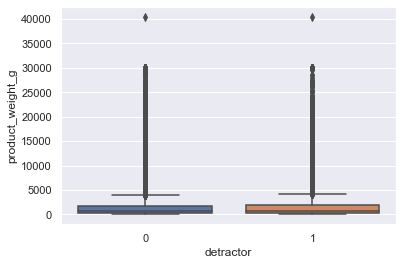

In [291]:
sns.boxplot(
    data=tb_pedidos,
    x="detractor",
    y="product_weight_g",
)


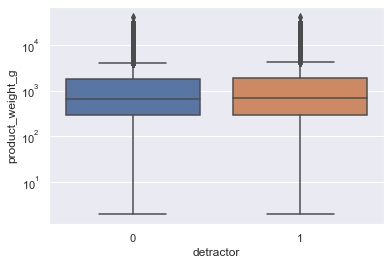

In [292]:
g = sns.boxplot(
    data=tb_pedidos[tb_pedidos["product_weight_g"] > 0],
    x="detractor",
    y="product_weight_g",
)
g.set_yscale("log")


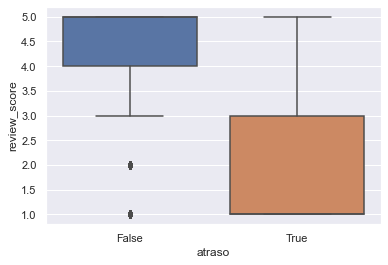

In [293]:
g = sns.boxplot(data=tb_pedidos, x="atraso", y="review_score")


In [294]:
mask_out = (~tb_pedidos["atraso"]) & (tb_pedidos["review_score"] <= 3)
tb_pedidos_out = tb_pedidos[mask_out].copy()


<AxesSubplot:xlabel='product_category_name', ylabel='count'>

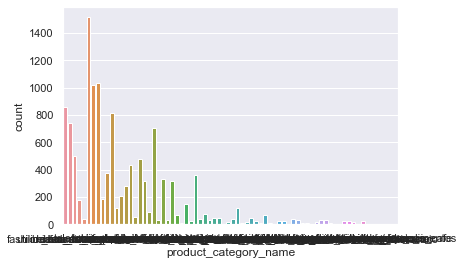

In [295]:
sns.countplot(data=tb_pedidos_out, x="product_category_name")


In [302]:
tb_cat_out = (
    tb_pedidos_out.groupby("product_category_name")["order_id"]
    .count()
    .reset_index()
    .rename({"order_id": "num_pedidos_out"}, axis=1)
)

tb_cat = (
    tb_pedidos.groupby("product_category_name")["order_id"]
    .count()
    .reset_index()
    .rename({"order_id": "num_pedidos_total"}, axis=1)
)

tb_cat = tb_cat.merge(tb_cat_out, on="product_category_name")
tb_cat["prop_total"] = tb_cat["num_pedidos_total"] / sum(tb_cat["num_pedidos_total"])
tb_cat["num_pedidos_out_expct"] = tb_cat["prop_total"] * sum(tb_cat["num_pedidos_out"])
tb_cat["diff_pedidos_out"] = tb_cat["num_pedidos_out"] - tb_cat["num_pedidos_out_expct"]


<AxesSubplot:xlabel='diff_pedidos_out', ylabel='Count'>

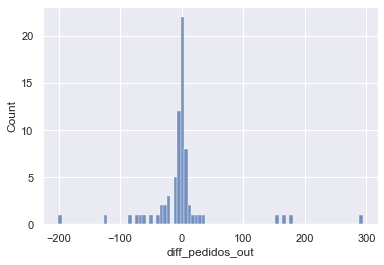

In [304]:
sns.histplot(data=tb_cat, x="diff_pedidos_out")


In [307]:
cat_problema = set(
    tb_cat.loc[tb_cat["diff_pedidos_out"] > 100, "product_category_name"]
)
cat_problema


{'cama_mesa_banho',
 'informatica_acessorios',
 'moveis_decoracao',
 'moveis_escritorio'}

<AxesSubplot:xlabel='atraso', ylabel='review_score'>

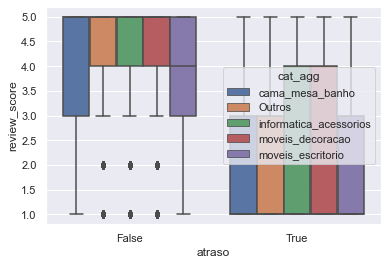

In [327]:
mask_cat = tb_pedidos["product_category_name"].map(lambda x: x in cat_problema)
tb_pedidos.loc[mask_cat, "cat_agg"] = tb_pedidos["product_category_name"]
tb_pedidos.loc[~mask_cat, "cat_agg"] = "Outros"
sns.boxplot(data=tb_pedidos, x="atraso", y="review_score", hue="cat_agg")


<AxesSubplot:xlabel='cat_agg', ylabel='review_score'>

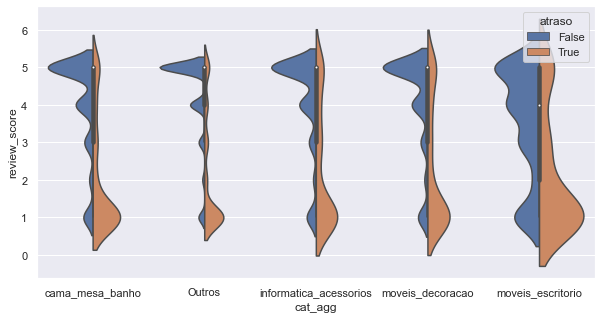

In [331]:
fig = plt.figure(figsize=(10, 5))
sns.violinplot(data=tb_pedidos, x="cat_agg", y="review_score", hue="atraso", split=True)


## Relação entre múltiplas variáveis continuas

In [333]:
tb_diaria.columns


Index(['order_approved_at', 'num_pedidos', 'avg_review', 'std_review',
       'per_detractor', 'per_atraso', 'avg_atraso', 'cv_review',
       'mm_num_pedidos', 'mm_avg_review', 'mm_cv_review', 'mm_per_detractor'],
      dtype='object')

In [335]:
var_original = [
    "num_pedidos",
    "avg_review",
    "std_review",
    "per_detractor",
    "per_atraso",
    "avg_atraso",
]
var_mm = ["mm_num_pedidos", "mm_avg_review", "mm_cv_review", "mm_per_detractor"]


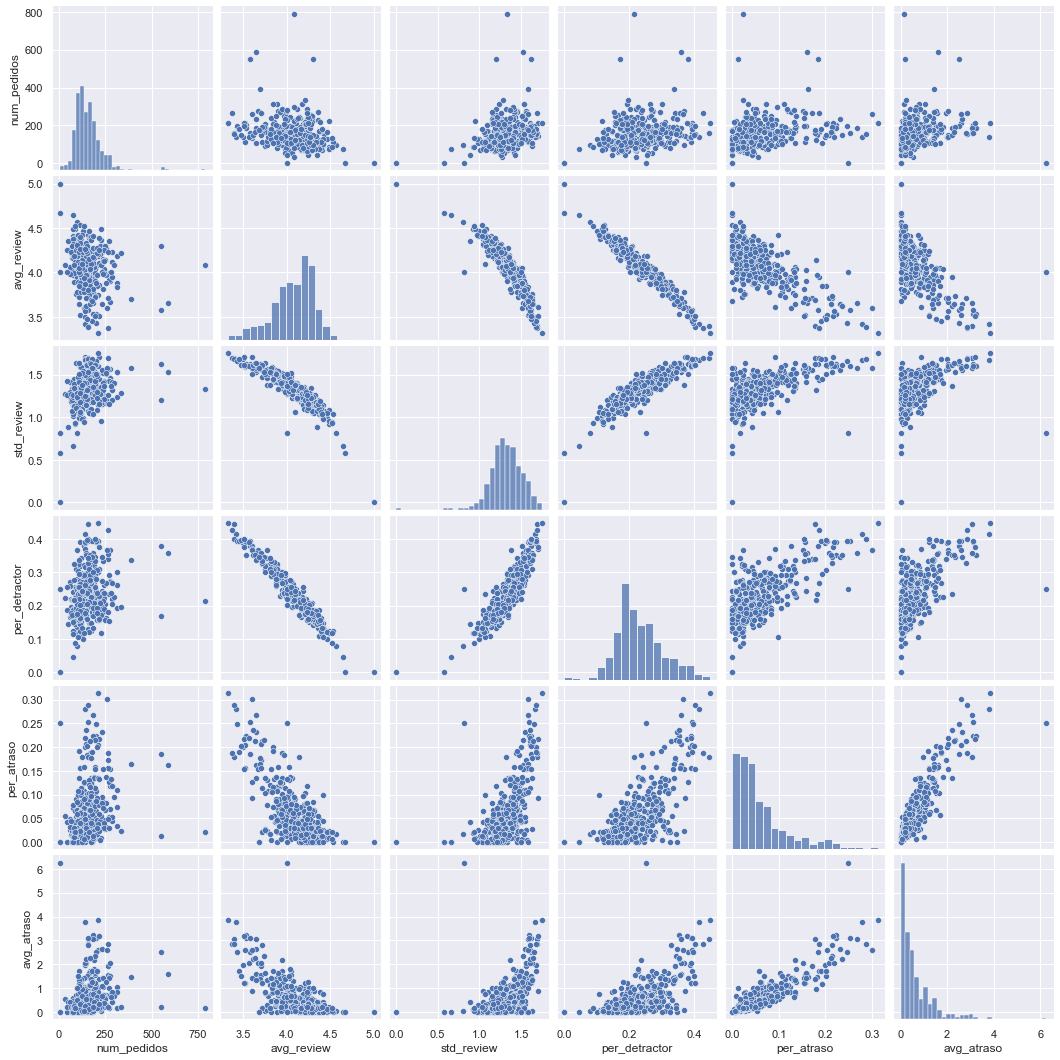

In [336]:
sns.pairplot(tb_diaria[var_original])


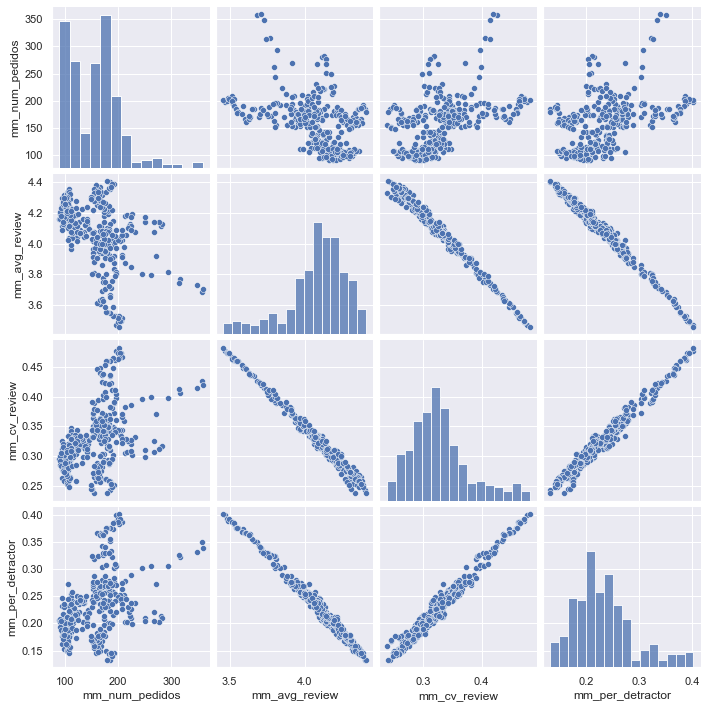

In [337]:
sns.pairplot(tb_diaria[var_mm])


<AxesSubplot:>

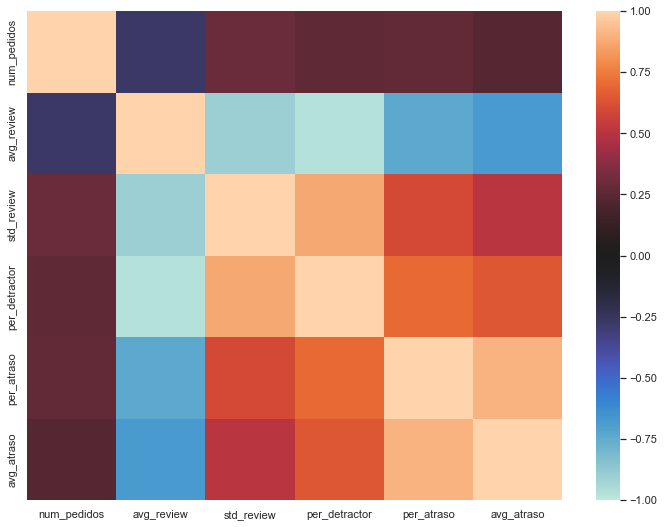

In [343]:
plt.figure(figsize=(12, 9))
sns.heatmap(tb_diaria[var_original].corr(), vmin=-1, center=0, vmax=1)


<Figure size 864x648 with 0 Axes>

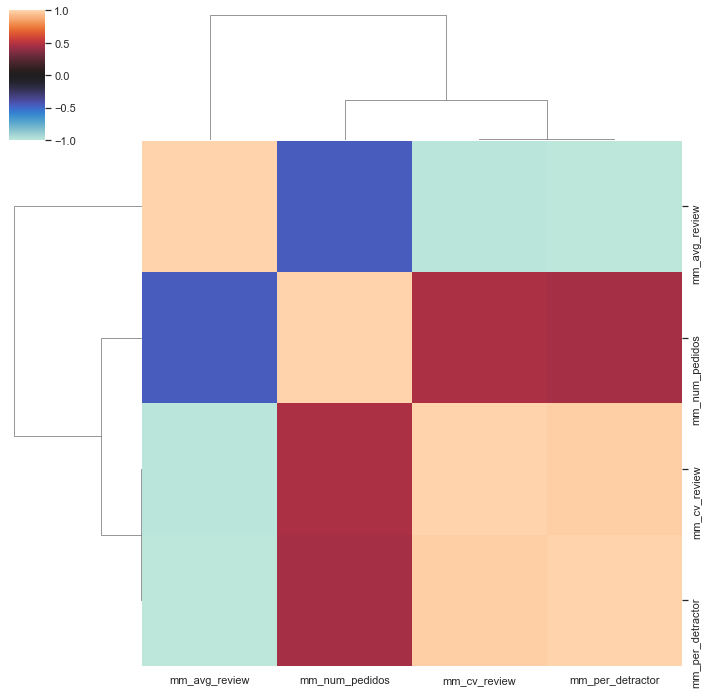

In [344]:
plt.figure(figsize=(12, 9))
sns.clustermap(tb_diaria[var_mm].corr(), vmin=-1, center=0, vmax=1)
